### 使用排斥的高阶耦合，实现爆炸同步现象

ref: A. Farrera-Megchun, P. Padilla-Longoria, G.J.E. Santos, J. Espinal-Enríquez, R. Bernal-Jaquez, Explosive synchronization driven by repulsive higher-order interactions in coupled neurons, Chaos, Solitons & Fractals 196 (2025) 116368.

model: Huber-Braun (HB) 模型

network: 规则网络 (六个节点，最近邻加权一阶网络，非加权二阶网络)

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
import random
import networkx as nx
import xgi
from scipy.sparse import coo_matrix
from joblib import Parallel, delayed
import sys
sys.path.append(r'../../')

# 方法导入
from algorithm import Euler, Heun, RK4, RKF45, discrete

In [90]:
seed = 0
random.seed(seed)
np.random.seed(seed)

#### 方法模型

In [91]:
method = RK4 # Euler

In [92]:
@njit
def Huber_Braun_model(vars, t, I):
    """
    Huber-Braun神经元模型的微分方程系统
    
    参数:
        vars: 状态变量数组 [V, a_r, a_sd, a_sr]
        t: 时间 (ms)
        I: 外部电流数组
        params: 模型参数数组 [g_d, g_r, g_sd, g_sr, g_L, E_d, E_r, E_sd, E_sr, E_L, 
                        s_d, s_r, s_sd, V_0d, V_0r, V_0sd, 
                        tau_r, tau_sd, tau_sr, eta, theta, C_m, temperature]
    
    返回:
        res: 导数数组 [dV/dt, da_r/dt, da_sd/dt, da_sr/dt]
    """
    res = np.zeros_like(vars)
    
    # 提取参数
    params = [1.5, 2.0, 0.25, 0.4, 0.1, 50., -90., 50., -90., -60., 0.25, 0.25, 0.09, -25., -25., -40., 2., 10., 20., 0.012, 0.17, 1.]
    (g_d, g_r, g_sd, g_sr, g_L, E_d, E_r, E_sd, E_sr, E_L,
     s_d, s_r, s_sd, V_0d, V_0r, V_0sd,
     tau_r, tau_sd, tau_sr, eta, theta, C_m) = params
    temperature = np.array([31.1128, 30.9716, 31.1508, 30.7853, 31.2447, 30.8477])  # 设置温度
    
    # 提取状态变量
    V, a_r, a_sd, a_sr = vars
    
    # 计算温度因子
    rho_T = 1.3 ** ((temperature - 25) / 10)  # 电流缩放因子
    phi_T = 3.0 ** ((temperature - 25) / 10)  # 动力学因子
    
    # 1. 快速去极化电流 (I_d) 的激活变量 (稳态值)
    a_d = 1.0 / (1.0 + np.exp(-s_d * (V - V_0d)))
    
    # 2. 快速复极化电流 (I_r) 的激活变量
    a_r_inf = 1.0 / (1.0 + np.exp(-s_r * (V - V_0r)))
    da_r_dt = phi_T * (a_r_inf - a_r) / tau_r + I[1]
    
    # 3. 慢速亚阈值去极化电流 (I_sd) 的激活变量
    a_sd_inf = 1.0 / (1.0 + np.exp(-s_sd * (V - V_0sd)))
    da_sd_dt = phi_T * (a_sd_inf - a_sd) / tau_sd + I[2]
    
    # 4. 计算I_sd电流值
    I_sd = rho_T * g_sd * a_sd * (V - E_sd)
    
    # 5. 慢速亚阈值复极化电流 (I_sr) 的激活变量
    da_sr_dt = phi_T * (-eta * I_sd - theta * a_sr) / tau_sr + I[3]
    
    # 计算所有离子电流
    I_d = rho_T * g_d * a_d * (V - E_d)
    I_r = rho_T * g_r * a_r * (V - E_r)
    I_sr = rho_T * g_sr * a_sr * (V - E_sr)
    I_L = g_L * (V - E_L)  # 漏电流不包含温度因子
    
    # 膜电位的导数
    dV_dt = (I[0] - I_d - I_r - I_sd - I_sr - I_L) / C_m
    
    # 输出结果
    res[0] = dV_dt
    res[1] = da_r_dt
    res[2] = da_sd_dt
    res[3] = da_sr_dt
    
    return res

@njit
def spikes_eval(mem, t, th_up, th_down, flag, flaglaunch, firingTime):
    """
        在非人工神经元中，计算神经元的 spiking
    """
    # -------------------- 放电开始 --------------------
    flaglaunch[:] = 0                                           # 重置放电开启标志
    firing_StartPlace = np.where((mem > th_up) & (flag == 0))   # 放电开始的位置
    flag[firing_StartPlace] = 1                                 # 放电标志改为放电
    flaglaunch[firing_StartPlace] = 1                           # 放电开启标志
    firingTime[firing_StartPlace] = t                           # 记录放电时间

    #  -------------------- 放电结束 -------------------
    firing_endPlace = np.where((mem < th_down) & (flag == 1))   # 放电结束的位置
    flag[firing_endPlace] = 0  

In [93]:
@njit
def couple__order1(vars, pre_ids, post_ids, weights):
    # 计算膜电位差 (vj - vi)
    vj_vi = vars[pre_ids] - vars[post_ids]

    # 计算突触电流贡献
    currents = weights * vj_vi

    # 神经元数量
    num_neurons = len(vars)  # 突触后神经元总数

    # 累积电流贡献到突触后神经元
    Isyn = np.bincount(post_ids, weights=currents, minlength=num_neurons)

    return Isyn


@njit
def couple__order2(vars, pre_ids1, pre_ids2, post_ids, weights):
    vj_vk_vi = vars[pre_ids1] + vars[pre_ids2] - 2 * vars[post_ids]

    currents = weights * vj_vk_vi

    # 神经元数量
    num_neurons = len(vars)  # 突触后神经元总数

    # 累积电流贡献到突触后神经元
    Isyn = np.bincount(post_ids, weights=currents, minlength=num_neurons)

    return Isyn

#### 统计量

In [94]:
@njit
def record_spike_times(flaglaunch, t, spike_times, spike_counts, max_spikes):
    """
        记录峰值时间的函数，使用 njit 加速。

        参数：
            flaglaunch (ndarray): 刚开始放电的神经元标志数组。
            t (float): 当前时间。
            spike_times (ndarray): 存储峰值时间的二维数组。
            spike_counts (ndarray): 每个神经元已记录的峰值次数。
            max_spikes (int): 每个神经元最多记录的峰值次数。
    """
    N = flaglaunch.shape[0]
    for i in range(N):
        if flaglaunch[i] > 0.9 and spike_counts[i] < max_spikes:
            spike_times[i, spike_counts[i]] = t
            spike_counts[i] += 1

In [95]:
@njit
def calculate_kuramoto(spike_times, dt, min_spikes=0):
    """
        使用 spike_times 计算 Kuramoto Order Parameter (KOP)，并输出附加信息。
        
        参数：
            spike_times (ndarray): 形状为 (N, max_spikes) 的二维数组，包含所有神经元的放电时间，NaN 表示无效数据。
            dt (float): 时间步长。
            min_spikes (int): 最小的峰值数量，用于计算 KOP。
            
        返回：
            mean_kop (float): 平均 Kuramoto Order Parameter。
            kuramoto (ndarray): 每个时间点的 Kuramoto Order Parameter。
            phase (ndarray): 每个神经元的相位矩阵。
            peak_id (ndarray): 每个神经元的峰值编号（计算完整相位变化）。
            valid_interval (tuple): (first_last_spk, last_first_spk)，有效计算的时间区间。
    """
    N = spike_times.shape[0]  # 神经元数量

    # 1. 找到每个神经元的第一个和最后一个放电时间
    first_spikes = []
    last_spikes = []
    for neuron_idx in range(N):
        neuron_spkt = spike_times[neuron_idx][~np.isnan(spike_times[neuron_idx])]
        if len(neuron_spkt) > min_spikes:  # 确保神经元有有效放电记录
            first_spikes.append(neuron_spkt[0])
            last_spikes.append(neuron_spkt[-1])
 
    # 检查是否存在有效神经元
    if len(first_spikes) == 0 or len(last_spikes) == 0:
        raise ValueError("没有满足条件的神经元放电的最小值，请检查输入数据或降低 min_spikes 的值！")
    
    first_spikes = np.asarray(first_spikes, dtype=np.float64)
    last_spikes = np.asarray(last_spikes, dtype=np.float64)

    # 定义有效时间区间
    first_last_spk = np.max(first_spikes)  # 最早的最后一个首峰时间
    last_first_spk = np.min(last_spikes)   # 最晚的第一个尾峰时间

    # 限制时间范围
    if first_last_spk >= last_first_spk:
        raise ValueError("有效时间区间无效，请检查 spike_times 数据！")

    # 生成时间向量
    time_start = np.min(first_spikes)  # 最早的第一个峰时间
    time_end = np.max(last_spikes)    # 最晚的最后一个峰时间
    time_vec = np.arange(time_start, time_end, dt)

    # 2. 初始化相位矩阵和峰值编号矩阵
    phase = np.ones((N, len(time_vec))) * -1    # 初始化为无效值
    peak_id = np.ones((N, len(time_vec))) * -1  # 初始化为无效值

    # 3. 计算每个神经元的相位
    for neuron_idx in range(N):
        neuron_spkt = spike_times[neuron_idx][~np.isnan(spike_times[neuron_idx])]
        for i in range(len(neuron_spkt) - 1):
            # 找到对应的时间索引，确保在有效区间内
            ti = max(0, np.searchsorted(time_vec, neuron_spkt[i]))
            tf = min(len(time_vec), np.searchsorted(time_vec, neuron_spkt[i + 1]))

            if tf > ti:  # 确保索引范围有效
                # 插值和峰值编号
                phase[neuron_idx, ti:tf] = np.linspace(0, 2 * np.pi, tf - ti)
                peak_id[neuron_idx, ti:tf] = i

    # 4. 计算完整相位
    # full_phase = 2 * np.pi * peak_id + phase  # 计算完整相位（包含峰值编号）

    # 5. 剔除无效相位区域，并计算 Kuramoto Order Parameter
    idxs = np.where((time_vec > first_last_spk) & (time_vec < last_first_spk))[0]
    phase = phase[:, idxs]
    peak_id = peak_id[:, idxs]  # 剪切出定义的区间
    peak_id -= peak_id[:, :1]
    
    # 计算 Kuramoto Order parameter
    N, T = phase.shape  # 神经元数量和时间点数量

    exp_phase = np.exp(1j * phase) # 复数e指数

    # 手动计算每个时间点的平均值
    mean_complex = np.zeros(T, dtype=np.complex128)
    for t in range(T):
        for n in range(N):
            mean_complex[t] += exp_phase[n, t]
        mean_complex[t] /= N  # 求平均值

    # 计算 Kuramoto Order Parameter
    kuramoto = np.zeros(T, dtype=np.float64)
    for t in range(T):
        kuramoto[t] = np.sqrt(mean_complex[t].real**2 + mean_complex[t].imag**2)

    mean_kop = np.mean(kuramoto)  # 平均 KOP

    return mean_kop, kuramoto, phase, peak_id, (first_last_spk, last_first_spk)

#### 网络建立

In [96]:
@njit
def matrix_to_sparse(conn, weight_matrix=None):
    """
    将矩阵转换为稀疏矩阵
  
        参数：
        - conn: 连接矩阵(二元矩阵)
        - weight_matrix: 权重矩阵(可选)
    
        返回：
        - pre_ids   : 前节点的id
        - post_ids  : 后节点的id
        - weights   : 节点对的权重
    """
    # 获取非零连接（即有边）的位置
    post_ids, pre_ids = np.nonzero(conn)

    # 如果没有提供权重，使用全1
    if weight_matrix is None:
        weights = np.ones_like(post_ids, dtype=np.float64)
    else:
        # 强制转换为float64类型的权重矩阵
        weight = weight_matrix.astype(np.float64)
        
        # 根据非零位置获取对应权重
        weights = np.empty_like(post_ids, dtype=np.float64)
        for i in range(post_ids.shape[0]):
            weights[i] = weight[post_ids[i], pre_ids[i]]

    # 将结果整合为一个三列矩阵
    # ids_and_weights = np.vstack((pre_ids, post_ids, weights))

    return pre_ids, post_ids, weights

## 稀疏三维矩阵
@njit
def matrix_to_sparse_3d(conn, weight_matrix=None):
    """
    将三维矩阵转换为稀疏矩阵
    
    参数:
        conn (np.ndarray): 三维连接矩阵
        weight_matrix (np.ndarray): 权重矩阵(可选)
    
    返回:
        tuple: 稀疏矩阵的行索引、列索引和权重
    """
    # 将 conn 转换为二元矩阵
    binary_conn = np.where(conn != 0, 1, 0)
  
    # 如果未提供权重矩阵，则默认为全1矩阵
    if weight_matrix is None:
        weight = np.ones_like(conn, dtype=np.float64)
    else:
        weight = np.asarray(weight_matrix, dtype=np.float64)

    # 确保 binary_conn 和 weight_matrix 形状一致
    if binary_conn.shape != weight.shape:
        raise ValueError("binary_conn 和 weight_matrix 的形状必须一致！")
  
    # 提取非零元素的行列索引
    post_ids, pre_ids, pre2_ids = np.nonzero(binary_conn)

    # 提取对应权重
    rows, cols, depth = weight.shape
    indices = post_ids * rows * cols + pre_ids * cols + pre2_ids
    weights = weight.ravel()[indices]  # 一维索引提取权重
    # 将结果整合为一个三列矩阵
    # ids_and_weights = np.vstack((pre_ids, pre2_ids, post_ids, weights))

    return pre_ids, pre2_ids, post_ids, weights

In [97]:
def create_nearest_neighbor_order2(n):
    """
        创建一个最近邻的二阶相互作用超图。
        每三个连续编号的节点组成一个超边。
        
        参数:
            n (int): 节点总数，n >= 3

        返回:
            xgi.Hypergraph: 构建好的超图对象
    """
    if n < 3:
        raise ValueError("节点数必须大于等于3")

    H = xgi.Hypergraph()
    H.add_nodes_from(range(n))

    for i in range(n):
        edge = [i, (i + 1) % n, (i + 2) % n]
        H.add_edge(edge)

    return H

## 构建二阶高阶网络
@njit
def build_second_order_network(N, triangles):
    """
    构建二阶网络。
    参数:
        N (int): 网络中节点的数量
        triangles (list): 三角形的列表

    返回:
        np.ndarray: 二阶网络的连接矩阵(post, pre1, pre2)
    """
    # 创建一个三维矩阵，大小为 (N, N, N)，用于存储二阶网络的连接关系
    second_order_network = np.zeros((N, N, N), dtype=np.int8)

    for index, (i, j, k) in enumerate(triangles):
        second_order_network[i, j, k] = 1
        second_order_network[i, k, j] = 1
        second_order_network[j, i, k] = 1
        second_order_network[j, k, i] = 1
        second_order_network[k, i, j] = 1
        second_order_network[k, j, i] = 1

    return second_order_network

In [98]:
# 一阶相互作用
alpha_A = 3
A_w = np.array([
    [0, 1, 3**(-alpha_A/2), 0, 3**(-alpha_A/2), 1],
    [1, 0, 1, 3**(-alpha_A/2), 0, 3**(-alpha_A/2)],
    [3**(-alpha_A/2), 1, 0, 1, 3**(-alpha_A/2), 0],
    [0, 3**(-alpha_A/2), 1, 0, 1, 3**(-alpha_A/2)],
    [3**(-alpha_A/2), 0, 3**(-alpha_A/2), 1, 0, 1],
    [1, 3**(-alpha_A/2), 0, 3**(-alpha_A/2), 1, 0],
])

A_b = np.where(A_w > 1e-10, 1, 0)

pre_ids_A, post_ids_A, weights_A = matrix_to_sparse(A_b, A_w)

In [99]:
print(pre_ids_A)
print(post_ids_A)
print(weights_A)

[1 2 4 5 0 2 3 5 0 1 3 4 1 2 4 5 0 2 3 5 0 1 3 4]
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5]
[1.         0.19245009 0.19245009 1.         1.         1.
 0.19245009 0.19245009 0.19245009 1.         1.         0.19245009
 0.19245009 1.         1.         0.19245009 0.19245009 0.19245009
 1.         1.         1.         0.19245009 0.19245009 1.        ]


In [100]:
# 二阶相互作用
H = create_nearest_neighbor_order2(6)
triangles = np.array([list(e) for e in H.edges.members() if len(e) == 3])
B_b = build_second_order_network(6, triangles)
pre_ids_B, pre2_ids_B, post_ids_B, weights_B =  matrix_to_sparse_3d(B_b)

In [101]:
print(pre_ids_B)
print(pre2_ids_B)
print(post_ids_B)
print(weights_B)

print(B_b[0])
print(B_b[1])

[1 1 2 4 5 5 0 0 2 2 3 5 0 1 1 3 3 4 1 2 2 4 4 5 0 2 3 3 5 5 0 0 1 3 4 4]
[2 5 1 5 1 4 2 5 0 3 2 0 1 0 3 1 4 3 2 1 4 2 5 4 5 3 2 5 0 3 1 4 0 4 0 3]
[0 0 0 0 0 0 1 1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 3 4 4 4 4 4 4 5 5 5 5 5 5]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0 0 0 0 0 0]
 [0 0 1 0 0 1]
 [0 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 1 0 0 1 0]]
[[0 0 1 0 0 1]
 [0 0 0 0 0 0]
 [1 0 0 1 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 0]
 [1 0 0 0 0 0]]


In [102]:
def visualize_hypergraph(H, layout='spring', with_node_labels=False, node_size=10,
                         node_fc='tab:orange', node_ec='black',
                         edge_fc=None, edge_alpha=0.4,
                         edge_ec='black', edge_lw=1.5, figsize=(6, 6)):
    """
    可视化一个 xgi 超图对象（新版 xgi 兼容）

    参数:
        H (xgi.Hypergraph): 要可视化的超图
        layout (str): 节点布局方式，可选 'spring' 或 'circular'
        with_node_labels (bool): 是否显示节点标签
        node_size (int): 节点大小
        node_fc (str or list): 节点填充颜色
        node_ec (str): 节点边框颜色
        edge_fc (str): 超边填充色
        edge_alpha (float): 超边透明度
        edge_ec (str): 超边边框色
        edge_lw (float): 超边边框宽度
        figsize (tuple): 图像大小
    """
    # 获取布局
    if layout == 'spring':
        pos = xgi.barycenter_spring_layout(H)
    elif layout == 'circular':
        pos = xgi.circular_layout(H)
    elif layout == 'spiral':
        pos = xgi.spiral_layout(H)
    else:
        raise ValueError("layout 仅支持 'spring' 或 'circular'")

    # 如果 node_fc 是字符串，则为所有节点赋同样颜色
    if isinstance(node_fc, str):
        node_fc = [node_fc for _ in H.nodes]

    # 如果 node_ec 是字符串，也同理处理
    if isinstance(node_ec, str):
        node_ec = [node_ec for _ in H.nodes]

    # 绘图
    plt.figure(figsize=figsize)
    xgi.draw(
        H,
        pos=pos,
        with_node_labels=with_node_labels,
        node_fc=node_fc,
        node_ec=node_ec,
        node_size=node_size,
        edge_fc=edge_fc,
        edge_alpha=edge_alpha,
        edge_ec=edge_ec,
        edge_lw=edge_lw
    )
    plt.axis('off')
    plt.show()

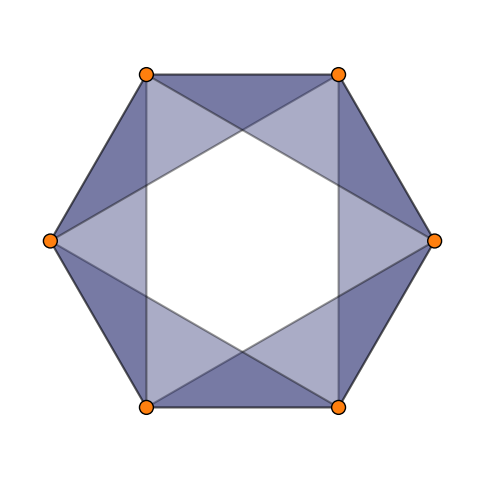

In [103]:
visualize_hypergraph(H, layout='circular')

In [104]:
@njit
def net(g_1_list, g_2, pre_ids_A, post_ids_A, weights_A, pre_ids_B, pre2_ids_B, post_ids_B, weights_B):
    N = 6  # 节点数量
    # 状态变量初始化
    # V0 = np.random.uniform(-.3, .3, N)
    # a_r0 = 1 * np.random.rand(N)
    # a_sd0 = 1 * np.random.rand(N)
    # a_sr0 = 1 * np.random.rand(N)
    V0 = np.ones(N)
    a_r0 = 1 * np.ones(N)
    a_sd0 = 1 * np.ones(N)
    a_sr0 = 1 * np.ones(N)
    vars_nodes = np.vstack((V0, a_r0, a_sd0, a_sr0))

    N_vars = 4  # 变量的数量

    dt = 0.01    # 时间步长
    th_up = -20      # 放电阈上值
    th_down = -20  # 放电阈下值
    
    
    # t = 0  # 运行时间
    # 初始化
    for i in range(200_00):
        I = np.zeros((N_vars, N))   
        method(Huber_Braun_model, vars_nodes, 0., dt, I)
        # spikes_eval(vars_nodes[0], t, th_up, th_down, flag, flaglaunch, firingTime)

        # t += dt

    mean_kop_list = np.zeros_like(g_1_list)  # 存储每个 g_2 的平均 Kuramoto Order Parameter

    for i_kop, g_1 in enumerate(g_1_list):

        # ============================== 需要初始化的量 ==============================
        # 放电状态设置
        flag = np.zeros(N, dtype=np.int8)           # 模型放电标志(>0, 放电)
        flaglaunch = np.zeros(N, dtype=np.int8)     # 模型开始放电标志(==1, 放电刚刚开始)
        firingTime = np.zeros(N)                     # 记录放电时间(上次放电)
        # 初始化峰值时间记录相关变量
        max_spikes = 1000                                 # 假设每个神经元最多记录 1000 次放电
        spike_times = np.full((N, max_spikes), np.nan)
        spike_counts = np.zeros(N, dtype=np.int32)   # 放电次数计数

        t = 0  # 运行时间
        # 初始化突触输入
        # mem = []  # 记录膜电位
        for i in range(1000_00):
            I = np.zeros((N_vars, N)) 

            I_A = couple__order1(vars_nodes[0], pre_ids_A, post_ids_A, weights_A)
            I_A = couple__order2(vars_nodes[0], pre_ids_B, pre2_ids_B, post_ids_B, weights_B)

            I[0] += g_1 * I_A + g_2 * I_A  # 一阶和二阶相互作用的突触输入

            method(Huber_Braun_model, vars_nodes, t, dt, I)

            spikes_eval(vars_nodes[0], t, th_up, th_down, flag, flaglaunch, firingTime)

            # mem.append(vars_nodes[0].copy())  # 记录膜电位

            t += dt
        
        # 计算同步
        cal_n = 5000_00

        for i in range(cal_n):
            I = np.zeros((N_vars, N)) 

            I_A = couple__order1(vars_nodes[0], pre_ids_A, post_ids_A, weights_A)
            I_A = couple__order2(vars_nodes[0], pre_ids_B, pre2_ids_B, post_ids_B, weights_B)

            I[0] += g_1 * I_A + g_2 * I_A  # 一阶和二阶相互作用的突触输入

            method(Huber_Braun_model, vars_nodes, t, dt, I)

            spikes_eval(vars_nodes[0], t, th_up, th_down, flag, flaglaunch, firingTime)
            
            record_spike_times(flaglaunch, t, spike_times, spike_counts, max_spikes)

            t += dt
        
        mean_kop, kuramoto, phase, peak_id, (first_last_spk, last_first_spk) = calculate_kuramoto(spike_times, dt, min_spikes=0)

        mean_kop_list[i_kop] = mean_kop  # 存储每个 g_2 的平均 Kuramoto Order Parameter
        
    # print(mean_kop)

    return mean_kop_list


In [105]:
g_1_list = np.arange(0.009, 0.011, 0.0001)  # 一阶相互作用强度列表
g_1_list2 = g_1_list[::-1].copy()  # 反向列表
# g_1_list = np.array([0.0104])
g_2 = -0.01

In [106]:
mean_kop_list = net(g_1_list, g_2, pre_ids_A, post_ids_A, weights_A, pre_ids_B, pre2_ids_B, post_ids_B, weights_B)

In [107]:
mean_kop_list2 = net(g_1_list2, g_2, pre_ids_A, post_ids_A, weights_A, pre_ids_B, pre2_ids_B, post_ids_B, weights_B)

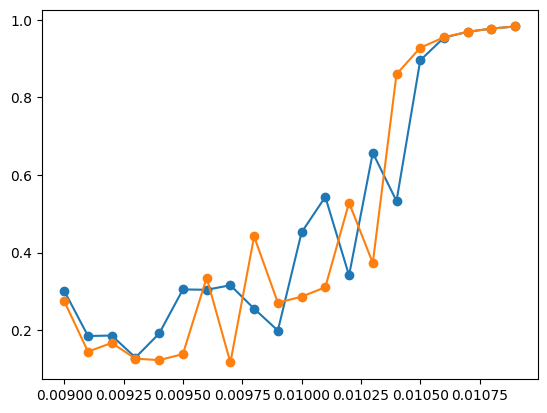

In [108]:
plt.plot(g_1_list, mean_kop_list, "o-")
plt.plot(g_1_list2, mean_kop_list2, "o-")
plt.show()